**DATA DIRI**


Nama : Alifia Feiling Asmoro Siwi

Username : alifiafas

IDCAMP : Machine Learning Developer

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [28]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import string
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Activation, Dense, Embedding, GlobalAveragePooling1D
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
import nltk
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

consumer = pd.read_csv("/content/consumer.csv")
consumer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Unnamed: 0,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,Company response,Timely response?,Consumer disputed?
0,0,1291006,Debt collection,NaN,Communication tactics,Frequent or repeated calls,TX,76119.0,2015-03-19,2015-03-19,"Premium Asset Services, LLC",In progress,Yes,NaN
1,1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479.0,2015-03-19,2015-03-19,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,NaN
2,2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",NaN,MA,2127.0,2015-03-19,2015-03-19,RBS Citizens,Closed with explanation,Yes,Yes
3,3,1291615,Credit card,NaN,Other,NaN,CA,92592.0,2015-03-19,2015-03-19,Navy FCU,In progress,Yes,NaN
4,4,1292165,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,NaN,43068.0,2015-03-19,2015-03-19,Transworld Systems Inc.,In progress,Yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28151,28151,1178184,Debt collection,NaN,Cont'd attempts collect debt not owed,Debt is not mine,TX,75201.0,2015-01-01,2015-01-02,"Enhanced Recovery Company, LLC",Closed with non-monetary relief,Yes,No
28152,28152,1178183,Consumer loan,Vehicle loan,Taking out the loan or lease,NaN,GA,30043.0,2015-01-01,2015-01-07,DriveTime,Closed with explanation,Yes,NaN
28153,28153,1178182,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,MN,55105.0,2015-01-01,2015-01-02,Regions,Closed with non-monetary relief,Yes,No
28154,28154,1178181,Payday loan,NaN,Can't stop charges to bank account,NaN,CA,92509.0,2015-01-01,2015-01-07,Moneytree Inc,Closed with explanation,Yes,NaN


In [29]:
consumer.isnull().sum()

Unnamed: 0                  0
Complaint ID                0
Product                     0
Sub-product             10574
Issue                       2
Sub-issue               14945
State                     421
ZIP code                  280
Date received               0
Date sent to company        0
Company                     0
Company response            0
Timely response?            0
Consumer disputed?      22150
dtype: int64

In [30]:
consumer.dtypes

Unnamed: 0                int64
Complaint ID              int64
Product                  object
Sub-product              object
Issue                    object
Sub-issue                object
State                    object
ZIP code                float64
Date received            object
Date sent to company     object
Company                  object
Company response         object
Timely response?         object
Consumer disputed?       object
dtype: object

In [31]:
consumer.shape

(28156, 14)

In [32]:
consumer.describe

<bound method NDFrame.describe of        Unnamed: 0  Complaint ID  ... Timely response? Consumer disputed?
0               0       1291006  ...              Yes                NaN
1               1       1290580  ...              Yes                NaN
2               2       1290564  ...              Yes                Yes
3               3       1291615  ...              Yes                NaN
4               4       1292165  ...              Yes                NaN
...           ...           ...  ...              ...                ...
28151       28151       1178184  ...              Yes                 No
28152       28152       1178183  ...              Yes                NaN
28153       28153       1178182  ...              Yes                 No
28154       28154       1178181  ...              Yes                NaN
28155       28155       1178180  ...              Yes                Yes

[28156 rows x 14 columns]>

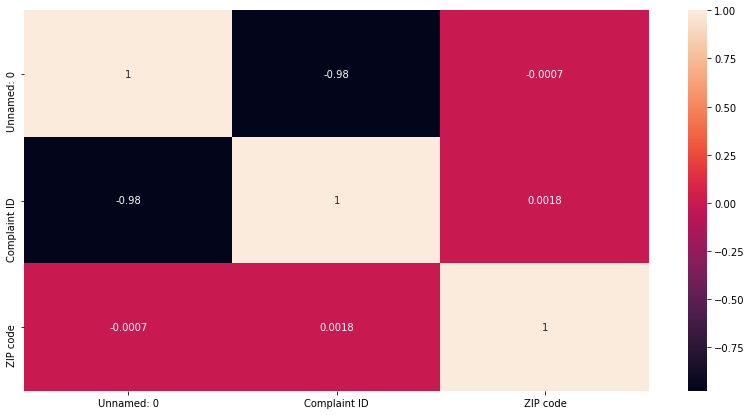

In [33]:
plt.figure(figsize=(14,7))
sns.heatmap(consumer.corr(method='kendall'), annot=True )

In [34]:
consumer = consumer.reset_index(drop=True)
ganti_re = re.compile('[/(){}\[\]\|@,;]')
simbolburuk = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def bersihkan_teks(teks):
    """
        text: a string
        
        return: modified initial string
    """
    teks = str(teks).lower() 
    teks = ganti_re.sub(' ', teks)
    teks = simbolburuk.sub('', teks) 
    teks = teks.replace('x', '')

    teks = ' '.join(word for word in teks.split() if word not in STOPWORDS)
    return teks
consumer['Issue'] = consumer['Issue'].apply(bersihkan_teks)

In [35]:
consumer['Issue'] = consumer['Issue'].str.replace('\d+', '')

In [36]:
maks_kata = 50000

maks_length = 250

embedding_dim= 100

tokenizer = Tokenizer(num_words=maks_kata, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(consumer['Issue'].values)
word_index = tokenizer.word_index
print('Menemukan %s token unik.' % len(word_index))

Menemukan 168 token unik.


In [37]:
X = tokenizer.texts_to_sequences(consumer['Issue'].values)
X = pad_sequences(X, maxlen=maks_length)
print('Ukuran tensor x : ', X.shape)

Ukuran tensor x :  (28156, 250)


In [38]:
Y = pd.get_dummies(consumer['Product']).values
print('Ukuran tensor y:', Y.shape)

Ukuran tensor y: (28156, 11)


In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(22524, 250) (22524, 11)
(5632, 250) (5632, 11)


In [40]:
model = Sequential()
model.add(Embedding(maks_kata, embedding_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 100)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1111      
Total params: 5,081,511
Trainable params: 5,081,511
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
epochs = 5
batch_size = 256

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
71/71 [==============================] - 138s 2s/step - loss: 1.8304 - accuracy: 0.4327 - val_loss: 0.4118 - val_accuracy: 0.9330
Epoch 2/5
71/71 [==============================] - 133s 2s/step - loss: 0.2944 - accuracy: 0.9404 - val_loss: 0.0842 - val_accuracy: 0.9791
Epoch 3/5
71/71 [==============================] - 134s 2s/step - loss: 0.0772 - accuracy: 0.9816 - val_loss: 0.0406 - val_accuracy: 0.9940
Epoch 4/5
71/71 [==============================] - 134s 2s/step - loss: 0.0445 - accuracy: 0.9918 - val_loss: 0.0289 - val_accuracy: 0.9938
Epoch 5/5
71/71 [==============================] - 133s 2s/step - loss: 0.0309 - accuracy: 0.9936 - val_loss: 0.0231 - val_accuracy: 0.9940


In [42]:
akurasi = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(akurasi[0],akurasi[1]))

176/176 [==============================] - 12s 64ms/step - loss: 0.0270 - accuracy: 0.9922
Test set
  Loss: 0.027
  Accuracy: 0.992


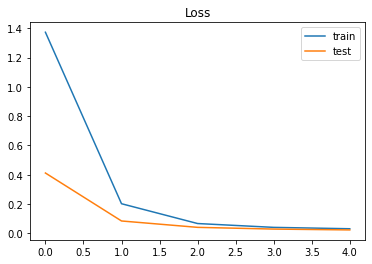

In [43]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

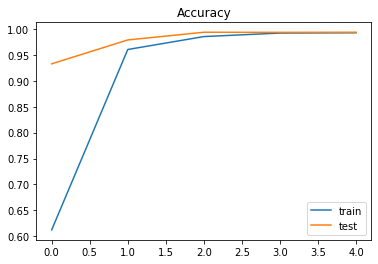

In [44]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

### **Lampiran DATA DIRI di dicoding**

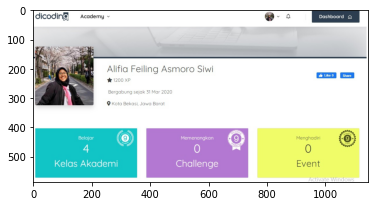

In [45]:
import matplotlib.image as mpimg
img = mpimg.imread('/content/Data diri Alifia Feiling.jpg')
imgplot = plt.imshow(img)
plt.show()